# Wordle Bot: v2.0.0

---

_Author: Stephen Menary  [Original 26/01/2022,  Last updated 26/01/2022]_

---


##  Summary

In WordleBot v1, we picked words based on heuristic notions of exploration and exploitation. Whilst empirically this seemed to work well, it had an insurmountable drawback: it cannot "plan ahead". This means that it cannot make the argument "If I guess word A now and then either B or C afterwards (based on the information learned), I will on-average reach the true answer quicker than if I guess word D now, even though I estimate that D has a higher immediate return than A". For example, human players sometimes find that guessing "ADIEU" as their first word provides a lot of information about which vowels are present, but restricts the performance of their _second_ guess because they are forced to re-use vowels for which they already have enough information. This seems to be a small drawback in practice, but would be conceptually nice to overcome. I am also interested in how much performance, if any, could be gained by applying forward-planning reasoning in an optimal way.

In this notebook we attempt to create a wordlebot which can "plan ahead". To do this, we forget about the exploration/exploitation heuristics and instead **pick whatever word provides the lowest expected number of turns to win** at every step. This is the same as implementing a greedy policy with a known optimal value function. As defined by this measure of success, we necessarily strike the optimal exploration/exploitation tradeoff without the need for an approximate parameterisation.

The question becomes: how well can we estimate this quantity?

Consider that we have a set of possible words $\mathbb{W}_\text{all-words}$. At any time-step in the game, the current state $s \in \mathbb{S}$ is defined as the set of answers $\mathbb{A} \subset \mathbb{W}_\text{all-words}$ which have not yet been excluded. The state is _independent_ of how we arrived there - once we know what answers are still possible, we do not need to know anything about what was guessed on previous time-steps, or what constraints have been amassed thus far.

Once in state $s$, we can guess any word $g \in \mathbb{G}$. This will transform us into a new state $s'$. This transition is stochastic, since it is selected deterministically according to the (hidden) true answer $a_\text{true}$. Since we know that $a_\text{true}$ must be uniformly distributed across $\mathbb{A}$, we can infer the probability distribution $p\left(s'|s,g\right)$ for transitioning into each possible state $s'$. Note that $s'=s$ in cases when our guess $g$ does not change the set of possible answers, e.g. when repeating a guess from a previous turn.

Since our objective is to minimise the expected number of turns taken to play the game, we assign a reward of $r=-1$ for every turn taken. Say that the game is on time-step $t$. The return amassed between now and the end of the game on time-step $T$ is $G_t = r_{t+1} + r_{t+2} + \dots + r_{T+1}$. Note that we label the reward on the time-step _after_ the guess, so that guess $g_t$ on time-step $t$ is rewarded by an amount $r_{t+1}$. We add one special state to the state space $\mathbb{S}$: the _terminal state_, which we transition to on time-step $T$ when we guess the correct answer. This transition still comes with a reward of $r_{T+1}=-1$, but it ends the game, so no further turns need to be taken (and so no more negative rewards accrued).

Note that the observed return $G_t$ is undiscounted because our games will eventually end, and so we do not suffer from an infinite horizon problem. Furthermore, we do not wish to weight the rewards of earlier turns differently to those of later turns if we can avoid it.

Since our game is defined by
- the current state $s \in \mathbb{S}$
- possible actions $g \in \mathbb{G}$ which induce stochastic transitions into new states according to probabilities $p\left(s'|s,g\right)$ (i.e. independently to the history of the game)
- a reward associated with the transition

then it is Markov Decision Process (MDP). We could try to solve this numerically using dynamic programming (e.g. through value iteration), or through RL methods such as $Q$-learning by performing repeated trials. We may try these later, but for now we will attempt to solve the game (almost) exactly. 

We assign the following objective: at every turn, we wish to guess whatever word will _minimise the expectation value of the number of turns required to win_. E.g. at time-step $t$, we find ourselves in state $t$ and wish to guess word g_t^* such that
\begin{align}
    Q\left(s_t,g_t\right) &= \mathbb{E}_{a_\text{true}} \left[ G_t \right] \\
    &= \mathbb{E}_{a_\text{true}} \left[ p\left(s_{t+1}|s_t,g_t\right) \times \text{argmax}_{g_{t+1}} Q\left(s_{t+1},g_{t+1}\right) \right] \\
    g_t^* &= \text{argmax}_{g_t} Q\left(s_t,g_t\right)
\end{align}
By writing the value function as $V\left(s\right) = \text{max}_{g_t} Q\left(s_t,g_t\right)$, this gives us the recursive equation
\begin{align}
    Q\left(s_t,g_t\right) &= \mathbb{E}_{a_\text{true}} \left[ p\left(s_{t+1}|s_t,g_t\right) \times V\left(s_{t+1}\right) \right] \\
    V\left(s_{t+1}\right) &= \text{max}_{g_{t+1}} ~\mathbb{E}_{a_\text{true}} \left[ p\left(s_{t+2}|s_{t+1},g_{t+1}\right) \times V\left(s_{t+2}\right) \right] \\
\end{align}

If playing well, this equation does not recurse forever, since every chain must end with $V(s_\text{terminal})=0$. However, when playing badly it may get stuck in loops since it must consider the possibility $s_{t+1}=s_t\forall t$. We know this to have a return of $-\infty$, however this cannot be specified without introducing new information into the state definition (such as what words have previously been guessed) which either (i) breaks the Markov property or (ii) explodes the size of the state space. Instead, we can exploit an interesting property, stated in two equivalent ways:
- if a guess causes the transition $s_{t+1} = s_t$ for some $a_\text{true}$, it must do this for all possible $a_\text{true}$ (i.e. a guess only provides _no_ information if it does so for _all_ states, otherwise the lack of information would _itself_ be information, which is a paradox).
- if a guess causes $s_{t+1} \neq s_t$ for any $a_\text{true}$, then it must do so for all others

Since guesses which do not change state _must_ have an expected return _worse or the same as_ any other guess, we can ignore them from the _argmax_ computation. Using the properties above, if we pick a _single possible answer_, ask whether each possible guess $g$ returns the same state, and discard the guess from consideration if so. By doing this, we must reject _all_ and _only_ guesses which provide no information, saving us from infinite loops.

We note that states with only one possible answer must satisfy $V\left(s\right)=-1 ~\forall~ |s|=1$, and those with two possible answers must satisfy $V\left(s\right)=-1.5 ~\forall~ |s|=2$. To simplify the state space, we will treat all one-answer states as terminal with an expected value of $-1$ (compared with $0$ for the terminal state representing a game win). We will not do this for two-answer states, but cross-check that they are evaluated with the correct expected value.

Our strategy is therefore as follows: at every turn, choose the guess which maximises $Q$. Each time we encounter a new state, we compute $V$ recursively and save it so that it can be retrieved next time we need it. In the recursive sum, we retrieve the $V$ for any already-evaluated states we encounter. Once $V$ is known for all states, the value of $Q$ can either be computed on-the fly (high computational cost, low memory) or backed up for quick access later on (low computational cost, high memory).

Using this approach, we learn the relevant parts of the value function on-the-fly by playing games. This means that we only need to evaluate states which might actually be visited during a game, and not all possible combinations of words. Each game we play, we may re-use any value functions evluated using past games. Once at least one game has been played for every $a_\text{true} \in \mathbb{W}_\text{all-words}$, we must have computed $V$ for all possible states, and no more evaluations need to be performed (only picking the best $Q$ at every turn).

However, the problem with this approach is one of combinatoric complexity. At every computation of $V\left(s_t\right)$, we must loop over all guesses, all possible answers, and all possible subsequent $s_{t+1}$. Even if the values for all subsequent states are known, this has a complexity of $\mathcal{O}\left(|\mathbb{G}|\cdot|\mathbb{A}|\cdot|\mathbb{S}_{t+1}|\right)$ where $\mathbb{S}_{t+1}$ is the number of possible next states for each combination of $g$ and $a_\text{true}$. The problem is compounded because the size of the state space $\mathbb{S}$ (and therefore both the size of $\mathbb{S}_{t+1}$ _and_ the number of calls to compute $V$) explodes as we allow recursion.

This combinatorial complexity is driven by the need to consider _all possible outcomes_ on _all possible turns_ between now and the end of the game. These are controlled by two interacting components:
1. the number of words in the game, $|\mathbb{W}_\text{all-words}|$.
2. the number of turns one must consider (depth of recursion).

When we consider all possible guesses, solving this game is therefore computationally intractable. Instead we attempt to simplify the computation in several ways:
- We always guess RAISE as the first word, which dramatically reduces the number of possible answers in the game (and so the size of the state space), and we only need to compute $V$ for the remaining states
- If $|\mathbb{A}| > 6$, we reduce the size of $\mathbb{G}$ to exclude any words which are not expected to remove at least 50% of words in $\mathbb{A}$. This means: when there are many possible answers, we only consider guesses which are expected to explore effectively. This removes the consideration of very-long games, in which we repeatedly make poor guesses leading to very deep recursion.
- Reduce the number of words in the game (currently solved for 500)
- When computing the argmax, further reduce the number of possible guesses to a random selection of 30, when the true number exceeds this, plus any possible answers which are not included. Random sampling 
- When computing the expectation over possible answers, reduce the number of possible answers to a random selection of 30, if the true number exceeds this

N.B. when randomly sampling subsets, we control the numpy random seed used to make this choice so that it makes the _same_ choice every time it runs again ont eh same state. This means that different games do not consider different subsets of possible guesses and answers, requiring re-computation for every game. 

In [427]:
###################################
###  Import required libraries  ###
###################################

import os, sys, time

import numpy as np
import pickle
from matplotlib import pyplot as plt

#  English words are defined using the english_words package
from english_words import english_words_set


In [2]:
#################################
###  Define global constants  ###
#################################
#
#  Define an allowed alphabet of allowedletters
#  We work in an environment where they all letters are upper case
#
alphabet = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N" \
           , "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

#  Define a function to verify that a word provided is length 5 and contains only allowed letters  
#
is_valid_word = lambda word : True if (len(word)==5 and np.sum([(letter in alphabet) for letter in word.upper()]) == 5) else False

#  Create a list of all 5-letter words from english_words_set
#
all_words = [w.upper() for w in english_words_set if len(w) == 5 and is_valid_word(w)]
print(f"{len(all_words)} five letter words found")


3194 five letter words found


In [331]:
################################
###  Define in-game methods  ###
################################
#
#  These methods are used to set up and play a game of Wordle
#     - they are directly copy+pasted from v1.1.0, since the game mechanics are identical
#       and our changes come from evaluation and optimisation
#

def initialise_possible_guesses(num_words=-1) :
    '''Returns list of all possible guesses at the game start'''
    if num_words < 0 or num_words >= len(all_words) :
        return sorted([w for w in all_words])
    return sorted(list(np.random.choice(all_words, size=(num_words,), replace=False)))

def initialise_possible_answers(num_words=-1) :
    '''Returns list of all possible answers at the game start'''
    if num_words < 0 or num_words >= len(all_words) :
        return sorted([w for w in all_words])
    return sorted(list(np.random.choice(all_words, size=(num_words,), replace=False)))
    
def remove_guess_from_possible_list(possible_guesses, guess_word, force_present=False) :
    '''Remove guess_word from the mutable list possible_guesses (require word to be present if force_present=True)'''
    if force_present and guess_word not in possible_guesses :
        raise ValueError(f"Guess '{guess_word}' not in possible_guesses list of length {len(possible_guesses)}")
    del possible_guesses[possible_guesses.index(guess_word)]

def guess(true_word, guess_word, possible_guesses=None) :
    '''Return the constraints learned by guessing guess_word if true_word is true.
       If mutable list possible_guesses is provided, remove guess_word from it'''
    # Initialise return containers. Constraints are:
    #  1. correct_spaces   = letters known to be in these positions
    #  2. incorrect_spaces = letters known to not be in these positions
    #  3. correct_letters  = letters known to be present in addition to any in correct_spaces, but position unknown
    #  4. absent_letters   = letters known to be absent, other than any in correct_spaces
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = [], [], [], []
    #  For every letter index, check if letters match. Store the results in correct_spaces and incorrect_spaces
    remove_idcs_from_word, reduced_guess_letters = [], []
    for l_idx, (tl, gl) in enumerate(zip(true_word, guess_word)) :
        if tl != gl :
            reduced_guess_letters.append(gl)
            incorrect_spaces.append((l_idx, gl))
            continue
        correct_spaces.append((l_idx, gl))
        remove_idcs_from_word.append(l_idx)
    #  Create a "reduced word" which does not include the known letters already confirmed to be correctly placed
    reduced_true_word = true_word
    for l_idx in remove_idcs_from_word[::-1] :
        reduced_true_word = reduced_true_word[:l_idx] + reduced_true_word[1+l_idx:]
    #  For any letters which were not correctly placed, ask whether they are present somewhere else
    #  - when one is found, remove it from the reduced word to prevent it being counter again
    #  - if letter found, store in correct_letters, otherwise store in absent_letters
    for guess_letter in reduced_guess_letters :
        guess_letter_idx = reduced_true_word.find(guess_letter)
        if guess_letter_idx >= 0 :
            correct_letters.append(guess_letter)
            reduced_true_word = reduced_true_word[:guess_letter_idx] + reduced_true_word[1+guess_letter_idx:]
        else :
            absent_letters.append(guess_letter)
    #  Remove repetitions in absent_letters
    absent_letters = set(absent_letters)
    #  If a list of possible_guesses, remove the word we have now guessed
    if type(possible_guesses) != type(None) :
        remove_guess_from_possible_list(possible_guesses, guess_word)
    #  Return the constraint containers we have populated
    return [correct_spaces, incorrect_spaces, correct_letters, absent_letters]

def update_constraints(old_constraints, new_constraints) :
    '''Return a set of constraints obtained by merging old_constraints and new_constraints'''
    # Separate the different constraint containers, and create new tmp_ version to store the combined versions
    old_correct_spaces, old_incorrect_spaces, old_correct_letters, old_absent_letters = old_constraints[0], old_constraints[1], old_constraints[2], old_constraints[3]
    new_correct_spaces, new_incorrect_spaces, new_correct_letters, new_absent_letters = new_constraints[0], new_constraints[1], new_constraints[2], new_constraints[3]
    tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters = [], [], [], []
    # Combine incorrect_spaces containers, which is just the union of the two separate versions
    tmp_incorrect_spaces = [item for item in old_incorrect_spaces]
    for (idx, letter) in new_incorrect_spaces :
        if (idx, letter) in old_incorrect_spaces : continue
        tmp_incorrect_spaces.append((idx, letter))
    tmp_incorrect_spaces.sort(key = lambda v: v[0])
    # Combine correct_spaces containers, which is also the union of the two separate versions
    tmp_correct_spaces   = [item for item in old_correct_spaces  ]  
    for (idx, letter) in new_correct_spaces :
        if (idx, letter) in old_correct_spaces : continue
        tmp_correct_spaces.append((idx, letter))
    # Combine correct_letters: this is more difficult because we need to account for any letters present in
    #   the correct_spaces container. We note that some letters may need to be moved from old_correct_letters
    #   to tmp_correct_spaces. Furthermore, a letter in new_correct_letters may already be present in
    #   old_correct_spaces and not need to be copied forwards. We resolve this mess by simply counting the total
    #   number of times the letter is green/yellow in both the old and new containers, count how many times the
    #   letter is green in the combined container, and assign anything remaining to the combined yellow container
    tmp_correct_letters = []
    for letter in set(new_correct_letters + old_correct_letters) :
        num_times_in_new_answer  = len([True for l in new_correct_letters if l==letter]) + len([True for (i,l) in new_correct_spaces if l==letter])
        num_times_in_old_answer  = len([True for l in old_correct_letters if l==letter]) + len([True for (i,l) in old_correct_spaces if l==letter])
        num_times_in_corr_spaces = len([True for (i,l) in tmp_correct_spaces if l==letter])
        num_times_expected       = np.max([num_times_in_new_answer, num_times_in_old_answer]) - num_times_in_corr_spaces
        for i in range(num_times_expected) : tmp_correct_letters.append(letter)
    # Combine absent_letters containers, which is also the union of the two separate versions
    tmp_absent_letters = [item for item in old_absent_letters  ]
    for letter in new_absent_letters :
        if letter not in tmp_absent_letters : tmp_absent_letters.append(letter)
    # Return combined constraints       
    return [tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters]
            
def get_expected_num_answers_excluded_by_guess(guess_word, possible_answers, old_constraints) :
    '''Return expectation value of fraction of list possible_answers excluded if we guess guess_word
       Account for existing knowledge contained in old_constraints'''
    # Create container for num_possible_answers which remain after we guess guess_word
    num_possible_answers = []
    # For every entry in possible_answers, assume this is the true word, then
    #  1. obtain the constraints learned by guessing guess_word
    #  2. combine these constraints with the knowledge we already have
    #  3. ask "what fraction of possible_answers are excluded by these combined constraints"
    #  4. add this fraction to num_possible_answers
    for possible_answer in possible_answers :
        new_constraints   = guess(possible_answer, guess_word)
        total_constraints = update_constraints(old_constraints, new_constraints)
        num_possible_answers.append(len(filter_possible_answers(possible_answers, total_constraints))/len(possible_answers))
    # Return 1 - mean(num_possible_answers), as well as the standard error in case this was a random sampling
    return (1-np.mean(num_possible_answers), np.std(num_possible_answers)/np.sqrt(len(num_possible_answers)))
    
def filter_possible_answers(possible_answers, constraints=[[], [], [], []], verbose=False) :
    '''Return a list of all entries from possible_answers which satisfy the given constraints'''
    # Separate constraints into individual containers
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = constraints[0], constraints[1], constraints[2], constraints[3]
    # Create return list
    tmp_possible_answers = []
    # Loop over all initially possible answers and add them to tmp_possible_answers only if they
    #  satisfy all of the provided constraints
    for possible_answer in possible_answers :
        # Use bool is_possible to check result of inner loops
        is_possible = True
        # Set is_possible to False and exit outer loop if any known spaces are not satisfied by possible_answer
        for (idx, letter) in correct_spaces :
            if possible_answer[idx] != letter :
                if verbose :
                    print(f"{possible_answer} failed because it doesn't have an {letter} at index {idx}")
                is_possible = False
        if not is_possible : continue
        # Set is_possible to False and exit outer loop if any known "letter is not here" spaces are not satisfied by possible_answer
        for (idx, letter) in incorrect_spaces :
            if possible_answer[idx] == letter :
                if verbose :
                    print(f"{possible_answer} failed because it has an {letter} at index {idx}")
                is_possible = False
        if not is_possible : continue
        # Create a "reduced word" which does not include the letters already verified
        remove_idcs_from_word = sorted([idx for (idx,letter) in correct_spaces])
        reduced_possible_answer = possible_answer
        for l_idx in remove_idcs_from_word[::-1] :
            reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        # Set is_possible to False and exit outer loop if any known letters are not present in reduced word
        #  If a letter is found, remove it from reduced word to prevent double counting
        for correct_letter in correct_letters : 
            l_idx = reduced_possible_answer.find(correct_letter)
            if l_idx < 0 :
                if verbose :
                    print(f"{possible_answer} failed because it doesn't have an {correct_letter} (reduced word is {reduced_possible_answer})")
                is_possible = False
            else :
                reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        if not is_possible : continue
        # Set is_possible to False and exit outer loop if any absent letters are present in reduced word
        for absent_letter in absent_letters :
            if absent_letter in reduced_possible_answer :
                if verbose :
                    print(f"{possible_answer} failed because it has an {absent_letter} (reduced word is {reduced_possible_answer})")
                is_possible = False
        if not is_possible : continue
        # If a word makes it this far, it has not been excluded by known constraints so we add it to return list
        tmp_possible_answers.append(possible_answer)
    # return list of allowed answers
    return tmp_possible_answers


In [532]:
##############################################################
###  Define methods for running wordlebot 2.0.0 algorithm  ###
##############################################################
#

def get_hash(lst) :
    '''Return the hash of a given list of objects'''
    return hash("".join([str(i) for i in lst]))

def get_expected_answers_after_guess(guess_word, true_word, possible_answers) :
    '''Return the reduced list possible_answers if we start with possible_answers and guess guess_word, when true_word is true'''
    new_constraints = guess(true_word, guess_word)
    return filter_possible_answers(possible_answers, new_constraints)

def get_value(values, possible_answers, possible_guesses, Na_sample=-1, Ng_sample=-1, req_improve=0., req_imp_limit=14, verbose=False, depth=0, extra_str="") :
    '''Return the value of a given state V(s)
       - values are a dictionary of V(s), which we add new entries to as they are recursively computed
       - possible_answers is the list of possible answers which define the state
       - possible_guesses is the list of possible guesses
       - Na_sample is the number of "possible answer" samples used to estimate the value (if <0 then no sampling)
       - Ng_sample is the number of "possible guess" samples used to estimate the value (if <0 then no sampling)
       - depth is the current recursive depth, used for printouts
       - verbose (bool) determines whether to print progress
       - req_improve is the expected fraction of answers excluded which we require for a guess to be considered
       - req_imp_limit is the minimum length of possible_answers before req_improve will be considered'''
    # If only one possible answer then value is -1
    if len(possible_answers) == 1 :
        return -1.
    # If only two possible answer then value is -1.5
    if len(possible_answers) == 2 :
        return -1.5
    # Get a hash representing the current state, used as the key of dictionary: values
    state_key = get_hash(possible_answers)
    # If state already in values, return this instead of computing
    if state_key in values : return values[state_key]
    # Otherwise index the global number of calls to get_value
    global num_call
    num_call += 1
    # Create a list reduced_possible_answers of possible answers used to compute expected value
    # - if sampling is requested, this is a subset of all possible answers, otherwise no reduction is performed
    reduced_possible_answers = possible_answers
    if Na_sample>0 and Na_sample<len(possible_answers) :
        np.random.seed(len(possible_answers))
        reduced_possible_answers = list(np.random.choice(possible_answers, size=(Na_sample,), replace=False))
    reduced_possible_answers = sorted(reduced_possible_answers)
    num_possible_answers = len(reduced_possible_answers)
    # - If a guess never provides any information then don't waste our time with it
    # - If a guess doesn't provide any information for one answer, then it doesn't for any other
    # - If a guess provides information for one answer, then it does for all others
    # - Therefore we only need to check whether each guess provides information for any one possible answer
    # Whilst we are doing it, store the "new_states" reached by each guess/answer pair to save time when we
    #  loop over these again
    reduced_possible_guesses = []
    guesses_to_pass_on       = []
    new_states               = {}
    for g in possible_guesses :
        # Take the first possible_answer as the true_word
        true_word     = reduced_possible_answers[0]
        # Get the new state we reach by guessing g
        new_state     = get_expected_answers_after_guess(g, true_word, reduced_possible_answers)
        new_state_key = get_hash(new_state)
        # If it is the same state, do not store it for future consideration
        if new_state_key == state_key : continue
        guesses_to_pass_on.append(g)
        # If it is a different state, ask what fraction of answers we expect it to exclude
        # - if it fails the threshold test, do not store it for future consideration
        frac_answers_removed = []
        for true_word in reduced_possible_answers :
            exp_answers = get_expected_answers_after_guess(g, true_word, reduced_possible_answers)
            new_states[(g, true_word)] = exp_answers
            if g == true_word : continue
            frac_answers_removed.append((num_possible_answers - len(exp_answers)) / num_possible_answers)
        frac_answers_removed = np.mean(frac_answers_removed)
        if req_improve > 0 and req_improve < 1 and num_possible_answers > req_imp_limit and frac_answers_removed < req_improve :
            continue
        # If a guess has passed both tests, store it for consideration when we argmax over action values
        reduced_possible_guesses.append(g)  
    #
    guesses_for_argmax = reduced_possible_guesses
    if Ng_sample>0 and Ng_sample<len(reduced_possible_guesses) :
        np.random.seed(len(reduced_possible_guesses))
        guesses_for_argmax = list(np.random.choice(reduced_possible_guesses, size=(Ng_sample,), replace=False))
    if len(reduced_possible_answers) < 10 :
        for possible_answer in reduced_possible_answers :
            if possible_answer in guesses_for_argmax : continue
            guesses_for_argmax.append(possible_answer)
    guesses_for_argmax = sorted(guesses_for_argmax)
    # Create a list of all guesses we wish to optimise the action values over 
    # Print progress
    if num_call % 20 == 0 and verbose :
        sys.stdout.write(f"\rComputing value for state {num_call} at depth {depth} with {len(guesses_for_argmax)} possible guesses reduced from {len(possible_guesses)} and {len(reduced_possible_answers)} possible answers reduced from {len(possible_answers)} ({len(values)} states now fully evaluated) {extra_str} *******")   
    # Find which guess optimises the action values
    # - recursively call this function for any new state encountered
    # - terminate when we guess the correct answer (reward=-1, next value=0)
    max_v_over_g = -np.inf
    for g in guesses_for_argmax :
        val_g = 0
        for true_word in reduced_possible_answers :
            if g == true_word :
                v_state, reward = 0, -1
            else :
                new_state = new_states[(g, true_word)]
                v_state   = get_value(values, new_state, guesses_to_pass_on, 
                                      Na_sample=Na_sample, Ng_sample=Ng_sample, depth=depth+1,
                                      req_improve=req_improve, req_imp_limit=req_imp_limit,
                                      verbose=verbose, extra_str=extra_str)
                reward    = -1
            val_g += v_state + reward
        val_g /= len(reduced_possible_answers)
        if val_g < max_v_over_g : continue
        max_v_over_g = val_g
    # Store computed value to values dictionary for quick access without computation in future
    values[state_key] = max_v_over_g
    # Return the computed value
    return max_v_over_g

def get_scores(values, possible_answers, possible_guesses, Na_sample=-1, Ng_sample=-1, req_improve=0., req_imp_limit=10, verbose=False) :
    '''Get expected return for all possible guesses, equivalent to action value Q(s,a)
       - values is a dictionary of previously computed values, which will be updated on-the-fly
       - possible_answers is the list of possible answers which defines the current state
       - possible_guesses is the list of possible guesses to consider
       - Na_sample is the number of "possible answer" samples used to estimate the value (if <0 then no sampling)
       - Ng_sample is the number of "possible guess" samples used to estimate the value (if <0 then no sampling)
       - req_improve: expected fraction of answers we must exclude with every guess
       - req_imp_limit: threshold at which to start filtering guesses according to req_improve
       - verbose: whether to print progress as we go'''
    # Reset global variable num_call to 1
    # - we will use this to count how many times get_value is called as we compute the score
    global num_call
    num_call = 1
    # If requested, sample from the possible_answers to reduce their number
    # - if so, do not pass Nsample argument to get_value because it will never have more possible_answers
    #   than the threshold for sampling
    reduced_possible_answers = possible_answers
    if Na_sample>0 and Na_sample<len(possible_answers) :
        np.random.seed(len(possible_answers))
        reduced_possible_answers = list(np.random.choice(possible_answers, size=(Na_sample,), replace=False))
    reduced_possible_answers = sorted(reduced_possible_answers)
    #
    guesses_for_argmax = possible_guesses
    if Ng_sample>0 and Ng_sample<len(possible_guesses) :
        np.random.seed(len(possible_guesses))
        guesses_for_argmax = list(np.random.choice(possible_guesses, size=(Ng_sample,), replace=False))
    if len(reduced_possible_answers) < 10 :
        for possible_answer in reduced_possible_answers :
            if possible_answer in guesses_for_argmax : continue
            guesses_for_argmax.append(possible_answer)
    guesses_for_argmax = sorted(guesses_for_argmax)
    # Create list to store (word, action-value) pairs in
    scores = []
    # Loop over possible guesses
    # - for each one, compute the expected return over possible answers
    # - if the guess is correct, return is 0, otherwise it is -1 + mean-value-of-next-states
    # - save expected return in scores container
    for g_idx, g in enumerate(guesses_for_argmax) :
        val_g = 0
        for true_word in reduced_possible_answers :
            if g == true_word :
                val_g += 0
            else :
                new_state = get_expected_answers_after_guess(g, true_word, reduced_possible_answers)
                val_g    += get_value(values, new_state, possible_guesses, Ng_sample=Ng_sample,
                                      verbose=verbose, req_improve=req_improve, req_imp_limit=req_imp_limit,
                                      extra_str=f"working on Q for guess {1+g_idx} / {len(guesses_for_argmax)}")
        val_g /= len(possible_answers)
        scores.append((g, val_g - 1))
    # If verbose then we print a line below the updates printed by get_value
    if verbose : sys.stdout.write("\n")
    # Sort the list of words so that the highest score is first
    scores.sort(key = lambda v : v[1], reverse=True)
    # Return list of scores
    return scores
    

In [586]:
##################################################################
###  Initialise a new dictionary of words to play wordle with  ###
##################################################################
#
#  If num_words > 0, randomly sample a subset of words from the full dictionary
#  This reduces the number of possible states and guesses, reducing complexity for easier computation
#

# Define number of words to play wordle with
num_words = 500

# Define first guess to be used for this Wordle, which we must ensure is contained in the dictionary
first_guess = "RAISE"

# Configure settings - only want to do this once per instance of state_values so we don't mix different settings
Na_sample     = -1      # If >0 then we estimate values using a subset of possible answers
Ng_sample     = -1      # If >0 then we estimate values using a subset of possible guess
req_improve   = 0.4     # Required improvement for a guess to be considered
req_imp_limit = 5       # Required num. possible answers before we threshold guesses according to req_improve

# Initialise the dictionary of V(s) - only want to do this once so we don't lose previously computed values!
state_values = {}

# Get words to play wordle with
reduced_words = sorted([w for w in all_words])
if num_words > 0 and num_words < len(all_words) :
    np.random.seed(num_words)
    reduced_words = list(np.random.choice(all_words, size=(num_words,), replace=False))
    if "RAISE" not in reduced_words :
        del reduced_words[-1]
        reduced_words.append("RAISE")
    reduced_words = sorted(reduced_words)


In [587]:
###############################################################
###  Play games of wordle to populate dictionary of values  ###
###############################################################
#
# Loop over all possible true words and play a wordle for each
# - populate values dictionary as we go
# - stop and re-run this cell to continue progress

# Get a shuffled list of all words in the game, for us to loop as possible answers
true_words = [w for w in reduced_words]
np.random.shuffle(true_words)

# Define containers to store game lengths
game_lengths = []
game_times   = []
total_turns  = 0

# Play games of wordle and store how many turns they took
start_time = time.time()
for game_idx, true_word in enumerate(true_words) :
    game_start_time = time.time()
    #sys.stdout.write(f"\rPlaying game {1+game_idx} / {len(true_words)} [{true_word}]")
    if game_idx == 0 : print(f"Playing game 1 / {len(true_words)} [{true_word}]")
    else             : print(f"Playing game {1+game_idx} / {len(true_words)} [{true_word}], avg {total_turns/game_idx:.2f} turns, elapsed time: {time.time()-start_time:.2f}s, {len(state_values)} states evaluated")
    possible_guesses = [w for w in reduced_words]
    possible_answers = [w for w in reduced_words]
    guess_word = first_guess
    num_turns  = 1
    while guess_word != true_word :
        constraints      = guess(true_word, guess_word, possible_guesses)
        possible_answers = filter_possible_answers(possible_answers, constraints)
        scores = get_scores(state_values, possible_answers, possible_guesses, Na_sample=Na_sample, Ng_sample=Ng_sample, verbose=True, req_improve=req_improve, req_imp_limit=req_imp_limit)
        guess_word = scores[0][0]
        num_turns += 1   
    game_lengths.append(num_turns)
    game_times  .append(time.time()-game_start_time)
    total_turns += num_turns
    

Playing game 1 / 500 [LIBEL]
Computing value for state 40 at depth 1 with 421 possible guesses reduced from 479 and 3 possible answers reduced from 3 (37 states now fully evaluated) working on Q for guess 8 / 499 *******

Playing game 2 / 500 [SENSE], avg 3.00 turns, elapsed time: 1.78s, 46 states evaluated


Playing game 3 / 500 [MISSY], avg 3.00 turns, elapsed time: 1.90s, 50 states evaluated

Playing game 4 / 500 [CAMEL], avg 2.67 turns, elapsed time: 1.91s, 50 states evaluated

Playing game 5 / 500 [POPPY], avg 2.50 turns, elapsed time: 2.04s, 54 states evaluated
Computing value for state 15220 at depth 2 with 469 possible guesses reduced from 496 and 12 possible answers reduced from 12 (15270 states now fully evaluated) working on Q for guess 478 / 499 *******


Playing game 6 / 500 [AGAVE], avg 2.80 turns, elapsed time: 1172.64s, 15275 states evaluated
Computing value for state 160 at depth 0 with 457 possible guesses reduced from 499 and 7 possible answers reduced from 7 (15433 



Playing game 49 / 500 [TWIRL], avg 3.00 turns, elapsed time: 6286.70s, 92717 states evaluated
Computing value for state 20 at depth 2 with 412 possible guesses reduced from 447 and 3 possible answers reduced from 3 (92733 states now fully evaluated) working on Q for guess 2 / 499 *******

Playing game 50 / 500 [TYLER], avg 3.00 turns, elapsed time: 6287.84s, 92752 states evaluated


Playing game 51 / 500 [KOALA], avg 3.00 turns, elapsed time: 6288.10s, 92752 states evaluated


Playing game 52 / 500 [INFIX], avg 3.00 turns, elapsed time: 6288.63s, 92752 states evaluated


Playing game 53 / 500 [BRONX], avg 3.00 turns, elapsed time: 6289.13s, 92752 states evaluated


Playing game 54 / 500 [SANTO], avg 3.00 turns, elapsed time: 6289.58s, 92752 states evaluated
Computing value for state 160 at depth 1 with 481 possible guesses reduced from 491 and 5 possible answers reduced from 5 (92909 states now fully evaluated) working on Q for guess 65 / 499 *******

Playing game 55 / 500 [PLACE], a



Playing game 122 / 500 [SHACK], avg 3.01 turns, elapsed time: 6454.97s, 95726 states evaluated


Playing game 123 / 500 [DEANE], avg 3.01 turns, elapsed time: 6455.04s, 95726 states evaluated


Playing game 124 / 500 [PECOS], avg 3.01 turns, elapsed time: 6455.11s, 95726 states evaluated


Playing game 125 / 500 [GLASS], avg 3.01 turns, elapsed time: 6455.27s, 95726 states evaluated


Playing game 126 / 500 [WALDO], avg 3.01 turns, elapsed time: 6455.29s, 95726 states evaluated



Playing game 127 / 500 [AKERS], avg 3.02 turns, elapsed time: 6455.70s, 95726 states evaluated


Playing game 128 / 500 [SHELL], avg 3.02 turns, elapsed time: 6455.72s, 95726 states evaluated



Playing game 129 / 500 [MINCE], avg 3.02 turns, elapsed time: 6455.89s, 95726 states evaluated


Playing game 130 / 500 [SPITZ], avg 3.02 turns, elapsed time: 6455.91s, 95726 states evaluated


Playing game 131 / 500 [FLINT], avg 3.02 turns, elapsed time: 6455.96s, 95726 states evaluated


Playing game 132 / 500 [IS



Playing game 207 / 500 [QUOTE], avg 3.00 turns, elapsed time: 6474.25s, 95734 states evaluated


Playing game 208 / 500 [KOMBU], avg 3.00 turns, elapsed time: 6474.49s, 95734 states evaluated


Playing game 209 / 500 [BRAVE], avg 3.00 turns, elapsed time: 6475.24s, 95734 states evaluated

Playing game 210 / 500 [DEWAR], avg 3.00 turns, elapsed time: 6475.25s, 95734 states evaluated
Computing value for state 40 at depth 1 with 425 possible guesses reduced from 465 and 4 possible answers reduced from 4 (95771 states now fully evaluated) working on Q for guess 153 / 499 *******

Playing game 211 / 500 [ENVOY], avg 3.00 turns, elapsed time: 6476.47s, 95776 states evaluated



Playing game 212 / 500 [WOMAN], avg 3.00 turns, elapsed time: 6476.97s, 95776 states evaluated


Playing game 213 / 500 [SAINT], avg 3.00 turns, elapsed time: 6477.47s, 95776 states evaluated

Playing game 214 / 500 [TRACK], avg 3.00 turns, elapsed time: 6477.47s, 95776 states evaluated

Playing game 215 / 500 [LOAT



Playing game 292 / 500 [STUPA], avg 3.01 turns, elapsed time: 6494.73s, 95776 states evaluated


Playing game 293 / 500 [RIVEN], avg 3.01 turns, elapsed time: 6494.81s, 95776 states evaluated

Playing game 294 / 500 [COYPU], avg 3.00 turns, elapsed time: 6494.81s, 95776 states evaluated


Playing game 295 / 500 [CAMEO], avg 3.00 turns, elapsed time: 6495.56s, 95776 states evaluated


Playing game 296 / 500 [QUEST], avg 3.00 turns, elapsed time: 6495.59s, 95776 states evaluated

Playing game 297 / 500 [DICTA], avg 3.00 turns, elapsed time: 6495.60s, 95776 states evaluated


Playing game 298 / 500 [GUISE], avg 3.00 turns, elapsed time: 6495.70s, 95776 states evaluated

Playing game 299 / 500 [SHUCK], avg 3.00 turns, elapsed time: 6495.71s, 95776 states evaluated


Playing game 300 / 500 [TORAH], avg 3.00 turns, elapsed time: 6495.81s, 95776 states evaluated


Playing game 301 / 500 [ADAPT], avg 3.00 turns, elapsed time: 6496.13s, 95776 states evaluated


Playing game 302 / 500 [SMILE],



Playing game 377 / 500 [BETEL], avg 2.98 turns, elapsed time: 6512.01s, 95776 states evaluated

Playing game 378 / 500 [BULLY], avg 2.98 turns, elapsed time: 6512.57s, 95776 states evaluated


Playing game 379 / 500 [TREAT], avg 2.98 turns, elapsed time: 6513.35s, 95776 states evaluated


Playing game 380 / 500 [PLUNK], avg 2.98 turns, elapsed time: 6513.41s, 95776 states evaluated



Playing game 381 / 500 [UPSET], avg 2.98 turns, elapsed time: 6514.20s, 95776 states evaluated

Playing game 382 / 500 [RIGGS], avg 2.98 turns, elapsed time: 6514.37s, 95776 states evaluated

Playing game 383 / 500 [PINTO], avg 2.98 turns, elapsed time: 6514.37s, 95776 states evaluated



Playing game 384 / 500 [STILL], avg 2.98 turns, elapsed time: 6514.92s, 95776 states evaluated


Playing game 385 / 500 [KHAKI], avg 2.98 turns, elapsed time: 6514.97s, 95776 states evaluated


Playing game 386 / 500 [BEZEL], avg 2.98 turns, elapsed time: 6515.05s, 95776 states evaluated


Playing game 387 / 500 [HAYDN




Playing game 463 / 500 [WYMAN], avg 2.99 turns, elapsed time: 6536.13s, 95776 states evaluated


Playing game 464 / 500 [FLUNK], avg 2.99 turns, elapsed time: 6536.64s, 95776 states evaluated



Playing game 465 / 500 [SPEED], avg 2.99 turns, elapsed time: 6537.44s, 95776 states evaluated


Playing game 466 / 500 [CHUMP], avg 2.99 turns, elapsed time: 6537.61s, 95776 states evaluated


Playing game 467 / 500 [CARTE], avg 2.99 turns, elapsed time: 6538.38s, 95776 states evaluated


Playing game 468 / 500 [PILOT], avg 2.99 turns, elapsed time: 6538.39s, 95776 states evaluated


Playing game 469 / 500 [ECOLE], avg 2.99 turns, elapsed time: 6538.91s, 95776 states evaluated


Playing game 470 / 500 [SLOTH], avg 2.99 turns, elapsed time: 6539.17s, 95776 states evaluated

Playing game 471 / 500 [TOWEL], avg 2.99 turns, elapsed time: 6539.25s, 95776 states evaluated


Playing game 472 / 500 [FLUNG], avg 2.99 turns, elapsed time: 6539.77s, 95776 states evaluated


Playing game 473 / 500 [TAB

In [588]:
######################################################################
###  Save the values we computed, and what words were in the game  ###
######################################################################
#

to_save = {"reduced_words":reduced_words, 
           "state_values" :state_values ,
           "Na_sample"    :Na_sample    ,
           "Ng_sample"    :Ng_sample    ,
           "req_improve"  :req_improve  ,
           "req_imp_limit":req_imp_limit}

version   = 0
get_fname = lambda : f".wordlebot2p0p0_example_{len(reduced_words)}words_v{version}.pickle"
while os.path.isfile(get_fname()) :
    version += 1
    
print(f"Saving words and state values to file {get_fname()}")
pickle.dump(to_save, open(f".wordlebot2p0p0_example_{len(reduced_words)}words_v{version}.pickle", "wb"))


Saving words and state values to file .wordlebot2p0p0_example_500words_v0.pickle


In [589]:
###############################################
###  Methods to plot results of many games  ###
###############################################

def histo_line(bins, hvals) :
    '''return x, y curve for histogram with bins 'bins' and values 'hvals' '''
    x = [bins[0]]
    for b in bins[1:-1] :
        x.append(b)
        x.append(b)
    x.append(bins[-1])
    y = []
    for v in hvals :
        y.append(v)
        y.append(v)
    return np.array(x), np.array(y)

def safe_divide(num, den) :
    '''Return num/den with nans when den=0'''
    return np.array([n/d if np.fabs(d)>0 else np.nan for n,d in zip(num, den)])

def make_and_save_plot(words, Na_sample, Ng_sample, req_improve, req_imp_limit, game_lengths, game_times, tag="") :
    '''Make and save a plot summarising the results of this experiment'''

    num_words      = len(words)
    num_games      = len(game_lengths)
    game_lengths   = np.array(game_lengths)
    num_turns_mean = np.mean(game_lengths)
    num_turns_std  = np.std (game_lengths)
    num_turns_SEM  = num_turns_std / np.sqrt(len(game_lengths))

    print(f"Mean number of turns is {num_turns_mean:.2f} +/- {num_turns_SEM:.2f}")
    print(f"Std  number of turns is {num_turns_std:.2f}")

    fig = plt.figure(figsize=(7, 5.5))
    ax  = fig.add_subplot(1, 1, 1)

    bin_min, bin_max = 1, int(np.max([6, np.max(game_lengths)])) + 1
    bins          = np.linspace(bin_min-0.5, bin_max+0.5, 2+bin_max-bin_min)
    overflow_bins = np.linspace(6.5, np.max([bin_max,7])+0.5, 2+np.max([bin_max,7])-7)

    h_absvals, _ = np.histogram(game_lengths, bins=bins)
    h_relvals    = h_absvals / len(game_lengths)
    h_abserrs    = np.sqrt(h_absvals)
    h_relerrs    = h_abserrs / len(game_lengths)

    hval_max = np.max(h_relvals+h_relerrs)

    h_split_idx = list(bins).index(6.5)

    x_blue, y_blue    = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx])
    x_blue, y_blue_hi = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] + h_relerrs[:h_split_idx])
    x_blue, y_blue_lo = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] - h_relerrs[:h_split_idx])

    ax.fill_between(x_blue, 0*y_blue , y_blue   , color="darkblue", alpha=0.3, label=f"Games won ({np.sum(game_lengths<7)})")
    ax.plot(x_blue, y_blue, color="darkblue", lw=2)
    ax.fill_between(x_blue, y_blue_lo, y_blue_hi, lw=0.5, color="none", ec="darkblue", hatch='//')

    x_red , y_red     = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:])
    x_red , y_red_hi  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] + h_relerrs[h_split_idx:])
    x_red , y_red_lo  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] - h_relerrs[h_split_idx:])

    ax.fill_between(x_red, 0*y_red , y_red   , color="darkred", alpha=0.3, label=f"Games lost ({np.sum(game_lengths>6)})")
    ax.plot(x_red, y_red, color="darkred", lw=2)
    ax.fill_between(x_red, y_red_lo, y_red_hi, lw=0.5, color="none", ec="darkred", hatch='//')

    ax.plot([6.5, 6.5], [0, hval_max], lw=2, ls="--", c="k", label="Win boundary")

    ax.set_xlabel("Turns taken to complete Wordle", rotation=0, fontsize=16, labelpad=20)
    ax.set_ylabel("Prob.\ndensity", rotation=0, fontsize=16, labelpad=40)
    ax.tick_params(axis="both", direction="in", top=True, right=True, labelsize=14)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 1.55*hval_max])
    ax.legend(loc="upper right", frameon=False, fontsize=13)

    ax.text(0.03, 0.96, r"$<t_{game}> = "+f"{np.mean(game_times):.2f} \pm {np.std(game_times)/np.sqrt(num_games):.2f}$ s", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.89, r"$N_{games}"+f"={num_games}"+r",~N_{A}="+f"{Na_sample},~"+r"N_{G}="+f"{Ng_sample}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.82, r"$N_{words}"+f"={num_words}$ (uniform prob)", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.03, 0.75, f"mean = ${num_turns_mean:.2f} \pm {num_turns_SEM:.2f}$, std = ${num_turns_std:.2f}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
    ax.text(0.02, 1.02, "WORDLE BOT v.2.0.0  [27/01/2022]", style="italic", fontsize=8, ha="left", va="bottom", transform=ax.transAxes)

    fname = f"Wordle_bot_v2p0p0_220127_{num_words}words_Na_{f'{Na_sample}'.replace('-','m')}_Ng_{f'{Ng_sample}'.replace('-','m')}_req_improve_{f'{req_improve}'.replace('.','p')}_threshold_{f'{req_imp_limit}'.replace('-','m')}"
    if len(tag) > 0 :
        fname += "_" + tag
    plt.savefig(f"{fname}.jpg", bbox_inches="tight", dpi=200)
    plt.savefig(f"{fname}.pdf", bbox_inches="tight")
    plt.show()


Mean number of turns is 2.98 +/- 0.02
Std  number of turns is 0.54


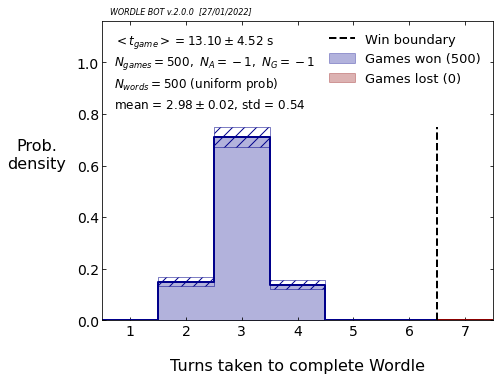

In [590]:

make_and_save_plot(reduced_words, Na_sample, Ng_sample, req_improve, req_imp_limit, game_lengths, game_times, tag="")
